## Ligand based pharmacophores

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
import numpy as np
import networkx as nx
import os

Load dataset of adenosine 2a receptor anagonists

572 molecules


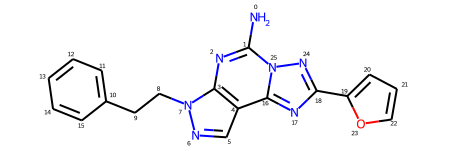

In [16]:
# Load inhibitors from smi file 
molecules = Chem.SmilesMolSupplier('./data/kutlushina2018/a2a.smi',delimiter='\t',titleLine=False)
print(f"{len(molecules)} molecules")
# Visualize first molecule
molecules[0]

Number of conformers: 0


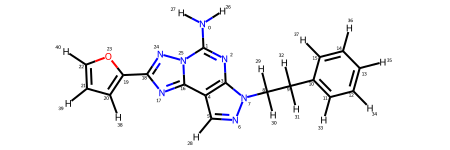

In [17]:
mymol = molecules[0]
print(f"Number of conformers: {mymol.GetNumConformers()}")
# Add hydrogens to generate realistic geometries
mymol = Chem.AddHs(mymol)
mymol

In [26]:
# Generate 10 conformers
cids = AllChem.EmbedMultipleConfs(mymol, numConfs=10)
rmslist = []
AllChem.AlignMolConformers(mymol, RMSlist=rmslist)
print(f"Number of conformers after generation: {mymol.GetNumConformers()}")

n_conformers = mymol.GetNumConformers()
n_atoms = mymol.GetNumAtoms()

indices = np.arange(n_atoms)
types = [mymol.GetAtomWithIdx(atom_indx).GetSymbol() for atom_indx in range(n_atoms)]
coordinates = np.zeros((n_conformers, n_atoms, 3))

for conformer in range(n_conformers):
    for atom_indx in range(n_atoms):
        position = mymol.GetConformer(conformer).GetAtomPosition(atom_indx)
        coordinates[conformer, atom_indx, 0] = position.x
        coordinates[conformer, atom_indx, 1] = position.y
        coordinates[conformer, atom_indx, 2] = position.z
    
# Take a look at a conformer coordinates
print(indices[0:5])
print(types[0:5])
print(coordinates[0, 0:5, :])

Number of conformers after generation: 10
[0 1 2 3 4]
['N', 'C', 'N', 'C', 'C']
[[ 1.86617333e+00 -1.43803461e-03  3.65555867e+00]
 [ 1.41025415e+00  2.58649165e-01  2.33672406e+00]
 [ 2.08375941e-01  8.15458160e-01  2.09891586e+00]
 [-1.94819014e-01  1.04928189e+00  8.37605434e-01]
 [ 5.89277256e-01  7.35630658e-01 -2.53584613e-01]]


In [31]:
bonded_atoms = []
for atom_idx in range(n_atoms):
    nbrs = [neighbor.GetIdx() for neighbor in mymol.GetAtomWithIdx(atom_idx).GetNeighbors()]
    bonded_atoms.append(nbrs)

np.array(bonded_atoms)

C:\Users\SRV DATOS\miniconda3\envs\pharmacophore\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


array([list([1, 26, 27]), list([0, 2, 25]), list([1, 3]), list([2, 4, 7]),
       list([3, 5, 16]), list([4, 6, 28]), list([5, 7]), list([6, 8, 3]),
       list([7, 9, 29, 30]), list([8, 10, 31, 32]), list([9, 11, 15]),
       list([10, 12, 33]), list([11, 13, 34]), list([12, 14, 35]),
       list([13, 15, 36]), list([14, 10, 37]), list([4, 17, 25]),
       list([16, 18]), list([17, 19, 24]), list([18, 20, 23]),
       list([19, 21, 38]), list([20, 22, 39]), list([21, 23, 40]),
       list([22, 19]), list([18, 25]), list([24, 1, 16]), list([0]),
       list([0]), list([5]), list([8]), list([8]), list([9]), list([9]),
       list([11]), list([12]), list([13]), list([14]), list([15]),
       list([20]), list([21]), list([22])], dtype=object)

In [4]:
# Load RDkit chemical features

fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [5]:
feats = factory.GetFeaturesForMol(mymol)

for feature in feats:
    feat_name = feature.GetFamily()
    idx = feature.GetAtomIds()
    if feat_name == 'LumpedHydrophobe':
        continue
    print(idx, feat_name)

(0,) Donor
(2,) Acceptor
(6,) Acceptor
(17,) Acceptor
(24,) Acceptor
(3, 4, 5, 6, 7) Aromatic
(16, 17, 18, 24, 25) Aromatic
(19, 20, 21, 22, 23) Aromatic
(1, 2, 3, 4, 16, 25) Aromatic
(10, 11, 12, 13, 14, 15) Aromatic
(4,) Hydrophobe
(9,) Hydrophobe
(10,) Hydrophobe
(11,) Hydrophobe
(12,) Hydrophobe
(13,) Hydrophobe
(14,) Hydrophobe
(15,) Hydrophobe
(20,) Hydrophobe
(21,) Hydrophobe


In [ ]:
def pharmacophore_graph(molecule, n_conformers):
    """
       Transform an rdkit molecule to a Networkx multigraph.
       Nodes are named by atom indices and they contain atom types and feature type.
       Edges represent bonds and they contain bond lenghts
    """
    Graph = nx.Graph()

    distances = get_bond_lenght(bonded_atoms, coords, indices)
    
    
    for i in range(len(indices)):
        Graph.add_node(indices[i], atom_name=names[i], atom_type=types[i], coordinates=coords[0, i, :])
        Graph.add_edge(bonded_atoms[i,0], bonded_atoms[i,1], bond_lenght=distances[i][0])
    
    return Graph

def get_bond_lenght(bonded_atoms, coordinates, indices):
    """Computes the distance between bonded atoms"""
    distance = np.zeros(bonded_atoms.shape[0]) # initialize distance array
    
    bonded_atoms_copy = copy(bonded_atoms) # create a coppy of the array so it's not modified
    
    coords_between_bonded_atoms = coordinates[bonded_atoms_copy] #matrix with pairs of coordiantes between bonded atoms
    bond_vectors = np.diff(coords_between_bonded_atoms, axis=1) #compute vectors for each pair of coordinates

    distance = LA.norm(bond_vectors, axis=-1)
    
    return distance